# Semantic Textual Similarity in SemEval 2012 RESULT: 0.78~

SemEval (Semantic Evaluation Exercises) are a series of workshops which have
the main aim of the evaluation and comparison of semantic analysis systems.
The data and corpora provided by them have become a ’de facto’ set of benchmarks
for the NLP comunity.
The SemEval event provide data and evaluation frameworks for several tasks.
One of them is Semantic Textual Similarity (STS), the purpose of this project.
All information of 2012’s edition is available at:
https://www.cs.york.ac.uk/semeval-2012/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from beautifultable import BeautifulTable

import os
from os import listdir, path as pth
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import csv

import numpy as np
from scipy.stats import pearsonr
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import spell
from nltk.tag import PerceptronTagger
from nltk.corpus import wordnet as wn
from nltk import word_tokenize
import nltk
import re
import nltk, string
from nltk import pos_tag
from nltk.metrics import jaccard_distance
from nltk.corpus import wordnet_ic
from nltk.corpus import wordnet as wn
from nltk.tag import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.metrics.pairwise import manhattan_distances as md
from sklearn.metrics.pairwise import euclidean_distances as ed
from sklearn.metrics import jaccard_similarity_score as jsc
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor


First set some variables needed, the lemmatizer, the tagger (using percentron, as seen in seassion 4 is the best). The scaler for the features extracted from the text and the corpus brown_ic

In [2]:
lemmatizer = WordNetLemmatizer()
tagger = PerceptronTagger()
en_stopwords = list(stopwords.words('english'))
scaler = StandardScaler()
brown_ic = wordnet_ic.ic('ic-brown.dat')

## Load and concatenate the datasets:
This is the first step. Change the train_path and test_path accordingly. Note that in windows the full path and the double back slash (\\\\) is needed

In [3]:
train_path = 'D:\\Users\\jsier\\Desktop\\MAI\\mai_ihlt\\project\\data\\train\\'
test_path = 'D:\\Users\\jsier\\Desktop\\MAI\\mai_ihlt\\project\\data\\test-gold\\'

def load_and_concat(data_path):
    files = listdir(data_path)
    input = pd.DataFrame(columns=['sentence0', 'sentence1'])
    label = pd.DataFrame(columns=['labels'])
    for file in files:
        path = pth.join(data_path, file)
        path_gs = path.replace('input', 'gs')
        if 'STS.input' in path:  # Only read input files
            print(path)
            print(path_gs)
            input_df = pd.read_csv(path, sep='\t', lineterminator='\n', names=['sentence0', 'sentence1'], header=None, quoting=csv.QUOTE_NONE)
            label_df = pd.read_csv(path_gs, sep='\t', lineterminator='\n', names=['labels'], header=None, quoting=csv.QUOTE_NONE)
            input = input.append(input_df)
            label = label.append(label_df)

    return \
        input.fillna('').reset_index(drop=True), \
        label.fillna('').reset_index(drop=True)


trn, trn_gs = load_and_concat(train_path)
tst, tst_gs = load_and_concat(test_path)

print('Train: {0} Test: {1}'.format(trn.shape, tst.shape))
print(trn.head())

D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\train\STS.input.MSRpar.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\train\STS.gs.MSRpar.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\train\STS.input.MSRvid.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\train\STS.gs.MSRvid.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\train\STS.input.SMTeuroparl.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\train\STS.gs.SMTeuroparl.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS.input.MSRpar.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS.gs.MSRpar.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS.input.MSRvid.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS.gs.MSRvid.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS.input.SMTeuroparl.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS.gs.SMTeuroparl.txt
D:\Users\jsier\Desktop\MAI\mai_ihlt\project\data\test-gold\STS

## First part of the preprocessing
The main function here is preprocessor_run which runs the first part of the preprocessing. It tokenizes the text, autorrects spell mistakes (Note ! Auto-correct is very slow, disabled by default). Then the preprocessor_remover takes away some symbols and stopwords, the tagger makes it work and then the lemmatizer.

The next step is expained later: preprocessor_meaning
The last part, just removes the tags and converts it into a normal vector again

In [4]:
def preprocessor_run(data):
    data = data.copy()

    auto_correct_remaining = len(data.index) * len(data.columns)
    for column in data.columns:
        data[column] = data[column].apply(word_tokenize)
        #data[column] = data[column].apply(preprocessor_auto_correct)
        data[column] = data[column].apply(preprocessor_remover)  # Remove stop words and symbols
        data[column] = data[column].apply(tagger.tag)
        data[column] = data[column].apply(preprocessor_lemmatize)
    print()

    for _, row in data.iterrows():
        preprocessor_meaning(row)

    for column in data.columns:
        data[column] = data[column].apply(preprocessor_revectorize)

    return data

def penn_to_wn(tag):
    if tag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    elif tag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif tag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    return wn.NOUN

auto_correct_remaining = 0
def preprocessor_auto_correct(vector):
    auto_correct_remaining -= 1
    print('\rSpell auto-correct...', auto_correct_remaining, 'sentences remain', end='    ', flush=True)
    return [spell(word) for word in vector]

def preprocessor_lemmatize(tagged):
    result = []
    for word, tag in tagged:
        # A verb for sure if it ends in ing (?).
        # Sometimes, verbs are wrongly classified, for example, "A man is smoking" (Smoking => Noun)
        if word.endswith('ing'):
            tag = 'VB'
        lemma = lemmatizer.lemmatize(word, penn_to_wn(tag))
        result.append((lemma, tag))
    return result

def preprocessor_remover(vector):
    new_vector = []
    for word in vector:
        word = re.sub(r'\.\d+', '', word)  # Remove decimals
        word = re.sub(r'\W+', '', word)  # Remove symbols
        word = re.sub(r'\s+', ' ', word)  # Replace multiple spaces by one
        word = re.sub(r'^\s+|\s+$', '', word) # Trim spaces

        if word and not (word in en_stopwords):
            new_vector.append(word)

    return new_vector


def preprocessor_revectorize(tagged): # And remove final s
    return [re.sub('s$', '', word).lower() for word, tag in tagged]

To be able to use the preprocessor_meaning, some code from seassion 5 (optional 1), have been used. Finds the shortest path between two synsets

In [5]:
def genData(word):
    hyper   = lambda s: s.hypernyms()
    synset  = wn.synset(word)
    tree    = synset.tree(hyper)
    closure = synset.closure(hyper)
    return tree, list(closure)


def listIntersec(list1, list2):
    return list(set(list1).intersection(set(list2)))


def pathTo(synset, tree, path=None):
    if path is None:
        path = []

    path += [tree[0]]

    if tree[0] == synset:
        return True, path  # Found

    for i in range(1, len(tree)):
        found, path = pathTo(synset, tree[i], path)
        if found: return True, path  # Found in child

    return False, path  # Not found


def lex_compare(A, B):
    treeA, closureA = genData(A)
    treeB, closureB = genData(B)
    closureA += [treeA[0]]  # Include the root in the closure
    closureB += [treeB[0]]  # Include the root in the closure
    common_hyper = listIntersec(closureA, closureB)  # Find which common hypernyms they both have in common

    min_dist = float('+inf')
    min_common = None
    min_pathA = []
    min_pathB = []

    for i in common_hyper:  # For each common hypernym, find the path from the root to the hypernym for both synsets
        pathA = pathTo(i, treeA, [])[1]
        pathB = pathTo(i, treeB, [])[1]
        dist = len(pathA) + len(pathB) - 2
        if dist < min_dist:  # If the total path is better than the one we had before, update it
            min_dist = dist
            min_common = i
            min_pathA = pathA
            min_pathB = pathB

    full_path = min_pathA[:-1] + min_pathB[::-1]  # Remove the repeated common word
    return full_path, min_common, min_dist

Now, the preprocessor_meaning function can be seen. It finds words that have a similar meaning

In [6]:
def preprocessor_meaning(row):

    s1 = row['sentence0']
    s2 = row['sentence1']

    for i1, (token1, tag1) in enumerate(s1):
        for i2, (token2, tag2) in enumerate(s2):
            if tag1 != 'DT' and tag2 != 'DT' and token1 != token2 and not is_number(token1) and not is_number(token2):
                # Check common starting or ending
                if  common_start(token1, token2) > 2 or common_end(token1, token2) > 3:
                    s1[i1] = (token1, tag1)
                    s2[i2] = (token1, tag2)
                    pass
                # Check similar verbs
                elif tag1.startswith('V') and tag2.startswith('V'):
                    synset1 = wn.synsets(token1, penn_to_wn(tag1))
                    synset2 = wn.synsets(token2, penn_to_wn(tag2))
                    if len(synset1) > 0 and len(synset2) > 0:
                        full_path, min_common, min_dist = lex_compare(
                            str(synset1[0]).replace('Synset(\'', '').replace('\')', ''),
                            str(synset2[0]).replace('Synset(\'', '').replace('\')', ''))

                        if  min_common is not None \
                            and min_dist < 4 \
                            and not str(min_common).startswith('Synset(\'entity') \
                            and not str(min_common).startswith('Synset(\'abstraction'):
                                s1[i1] = (re.sub(r'Synset\(\'(.*)\..*\..*', r'\1', str(min_common)), tag1)
                                s2[i2] = (re.sub(r'Synset\(\'(.*)\..*\..*', r'\1', str(min_common)), tag2)
    return row

def common_start(A, B):
    count = 0
    for a, b in zip(A, B):
        if a != b:
            return count
        count += 1
    return count

def common_end(A, B):
    count = 0
    for a, b in zip(reversed(A), reversed(B)):
        if a != b:
            return count
        count += 1
    return count

def preprocessor_get_synsets(word, tag):
    synsets = wn.synsets(word, penn_to_wn(tag))
    return [str(synset).replace('Synset(\'', '').replace('\')', '') for synset in synsets]

def is_number(s):
    try:
        float(s)
    except ValueError:
        return False
    else:
        return True

## The preprocessing can take place now

In [7]:
print('Preprocessing... Wait')
tok_trn = preprocessor_run(trn)
tok_tst = preprocessor_run(tst)
print(tok_trn.head())

Preprocessing... Wait


                                           sentence0  \
0  [but, source, close, sale, say, vivendi, keep,...   
1  [micron, declare, first, quarterly, profit, th...   
2  [the, fine, part, fail, republican, effort, fo...   
3  [the, american, anglican, council, represent, ...   
4  [the, techloaded, nasdaq, composite, rise, 20,...   

                                           sentence1  
0  [but, source, close, sale, say, vivendi, keep,...  
1  [micron, number, also, mark, first, quarterly,...  
2  [perry, say, back, senate, effort, include, fi...  
3  [the, anglican, anglican, council, represent, ...  
4  [the, techloaded, nasdaq, composite, index, ix...  


## Before the training, we extract some features 


### Feature extraction

In [8]:
def extract(dataset):
    features = pd.DataFrame(columns=['sentence_lenght_diff',
                                     'number_nouns_diff',
                                     'number_of_verbs_s0', 'number_of_verbs_s1',
                                     'number_of_symbols_s0', 'number_of_symbols_s1',
                                     'number_of_digits_s0', 'number_of_digits_1',
                                     'synonim_proportion', 'quantity_of_shared_words',
                                     'proper_nouns_shared', 'jaccard_distance', 'path_similarity',
                                     'wup_similarity', 'resnik_similarity', 'common_description',
                                     'jcn_similarity', 'lin_similarity'])

    mx = len(dataset.index)
    for index, row in dataset.iterrows():
        print('\rExtracting features...', index, 'of', mx, end='   ', flush=True)
        s0 = row['sentence0']
        s1 = row['sentence1']
        features.loc[index,'jaccard_distance'] = calculate_jaccard(s0,s1)
        features.loc[index,'resnik_similarity'] = sentence_similarity_information_content(s0,s1,wn.res_similarity)
        features.loc[index,'jcn_similarity'] = sentence_similarity_information_content(s0,s1,wn.jcn_similarity)
        features.loc[index,'lin_similarity'] = sentence_similarity_information_content(s0,s1,wn.lin_similarity)
        features.loc[index,'path_similarity'] = sentence_similarity(s0,s1,wn.path_similarity)
        features.loc[index,'wup_similarity'] = sentence_similarity(s0,s1,wn.wup_similarity)
        features.loc[index,'proper_nouns_shared'] = count_common_propper_nouns(s0,s1)
        features.loc[index,'quantity_of_shared_words'] = count_shared_words(s0,s1)
        features.loc[index,'synonim_proportion'] = synonim_proportion(s0,s1)
        features.loc[index,'sentence_lenght_diff'] = abs(sentence_lenght(s0) - sentence_lenght(s1))
        features.loc[index,'number_nouns_diff'] = abs(count_nouns(s0) - count_nouns(s1))
        features.loc[index,'number_of_verbs_s0'] = count_verbs(s0)
        features.loc[index,'number_of_verbs_s1'] = count_verbs(s1)
        features.loc[index,'number_of_symbols_s0'] = count_symbols(s0)
        features.loc[index,'number_of_symbols_s1'] = count_symbols(s1)
        features.loc[index,'number_of_digits_s0'] = count_digits(s0)
        features.loc[index,'number_of_digits_1'] = count_digits(s1)
        features.loc[index,'common_description'] = common_description(s0, s1)

    print()
    features['resnik_similarity'] = scaler.fit_transform(features[['resnik_similarity']].values)
    features['jcn_similarity'] = scaler.fit_transform(features[['jcn_similarity']].values)

    return features

def synonim_proportion(s0, s1):
    syn_count = 0
    for a in s0:
        a = a.lower()
        synonims_a = _get_word_synonyms(a)
        for b in s1:
            b = b.lower()
            synonims_b = _get_word_synonyms(b)
            if a == b:
                are_syns = 1
            else:
                are_syns = len(set(synonims_a) & set(synonims_b)) > 0
            syn_count += are_syns
    max_len = min([len(s0), len(s1)])
    return syn_count / max_len

def tagged_to_synset( word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None

def sentence_similarity_information_content(sentence1, sentence2, similarity):
    ''' compute the sentence similairty using information content from wordnet '''
    # Tokenize and tag
    sentence1 = pos_tag(sentence1)
    sentence2 = pos_tag(sentence2)
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]
    score, count = 0.0, 0
    ppdb_score, align_cnt = 0, 0
    # For each word in the first sentence
    for synset in synsets1:
        L = []
        for ss in synsets2:
            try:
                L.append(wn.similarity(synset, ss, brown_ic))
            except:
                continue
        if L:
            best_score = max(L)
            score += best_score
            count += 1
    # Average the values
    if count > 0: score /= count
    return score

def common_description(s0, s1):
    s0_tags = tagger.tag(s0)
    s1_tags = tagger.tag(s1)

    total_dist = 0
    for word, tag in s0_tags:
        if tag.startswith('N') or tag.startswith('V') or tag.startswith('J') or tag.startswith('R'):
            max_dist = 0
            for synset in wn.synsets(word, penn_to_wn(tag)):
                desc = word_tokenize(synset.definition())
                dist = len(list(set(s1) & set(desc)))
                if dist > max_dist:
                    max_dist = dist
            total_dist += max_dist

    for word, tag in s1_tags:
        if tag.startswith('N') or tag.startswith('V') or tag.startswith('J') or tag.startswith('R'):
            max_dist = 0
            for synset in wn.synsets(word, penn_to_wn(tag)):
                desc = word_tokenize(synset.definition())
                dist = len(list(set(s0) & set(desc)))
                if dist > max_dist:
                    max_dist = dist
            total_dist += max_dist

    return total_dist


def sentence_lenght(s):
    return len(s)

def count_symbols(s):
    count = lambda l1, l2: sum([1 for x in l1 if x in l2])
    return count(s, set(string.punctuation))

def count_shared_words(s0, s1):
    s0 = [w.lower() for w in s0]
    s1 = [w.lower() for w in s1]
    return len(list(set(s0) & set(s1)))

def count_digits(s):
    numbers = sum(c.isdigit() for c in s)
    return numbers

def _get_word_synonyms(word):
    word_synonyms = []
    for synset in wn.synsets(word):
        for lemma in synset.lemma_names():
            word_synonyms.append(lemma)
    return word_synonyms

def synonim_words(a, b):
    return len(set(_get_word_synonyms(a)) & set(_get_word_synonyms(b))) > 0

def count_synonims(s0, s1):
    sinonim = 0
    for a in s0:
        for b in s1:
            sinonim += synonim_words(a.lower(), b.lower())
    return sinonim

def count_common_propper_nouns(s0, s1):
    s0_tags = tagger.tag(s0)
    s1_tags = tagger.tag(s1)
    NNP_s0 = [values[0] for values in s0_tags if values[1] == 'NNP']
    NNP_s1 = [values[0] for values in s1_tags if values[1] == 'NNP']
    return len(set(NNP_s0) & set(NNP_s1))

def count_nouns(s0):
    tagger = PerceptronTagger()
    s0_tags = tagger.tag(s0)
    NN_s0 = [values[0] for values in s0_tags if values[1] == 'NN']
    return len(NN_s0)

def count_verbs(s0):
    tagger = PerceptronTagger()
    s0_tags = tagger.tag(s0)
    V_s0 = [values[0] for values in s0_tags if values[1] == 'VBP']
    return len(V_s0)

def calculate_jaccard(s0, s1):
    lemms_0 = set([a.lower() for a in s0 if a])
    lemms_1 = set([a.lower() for a in s1 if a])

    jaccard_simmilarity = (1 - jaccard_distance(lemms_0, lemms_1))
    return jaccard_simmilarity

def sentence_similarity(sentence1, sentence2, similarity=wn.path_similarity):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(sentence1)
    sentence2 = pos_tag(sentence2)

    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]

    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]

    score, count = 0.0, 0

    # For each word in the first sentence
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
        similarities = [similarity(synset, ss) for ss in synsets2 if similarity(synset, ss)]
        try:
            best_score = max(similarities)
        except:
            best_score = 0
        # Check that the similarity could have been computed
        if best_score is not None:
            score += best_score
            count += 1

    # Average the values
    try:
        score /= count
    except:
        score = 0
    return score

Extract the actual features

In [9]:
fea_trn = extract(tok_trn)
fea_tst = extract(tok_tst)

Extracting features... 2233 of 2234    3 of 2234    63 of 2234       82 of 2234    102 of 2234    128 of 2234    172 of 2234    175 of 2234    184 of 2234          334 of 2234   364 of 2234    389 of 2234    404 of 2234    427 of 2234    492 of 2234   of 2234    515 of 2234   517 of 2234   2234    532 of 2234       of 2234    640 of 2234    778 of 2234    795 of 2234    809 of 2234    846 of 2234    865 of 2234    875 of 2234    877 of 2234   886 of 2234    912 of 2234   961 of 2234   2234    977 of 2234       1008 of 2234    1021 of 2234   of 2234    1065 of 2234   2234    2234    1096 of 2234    1116 of 2234   1166 of 2234    1172 of 2234    2234    2234    1222 of 2234    1232 of 2234    1294 of 2234    1348 of 2234   of 2234    1371 of 2234    1399 of 2234    1455 of 2234   of 2234    2234    1484 of 2234    1485 of 2234   of 2234    1556 of 2234    1590 of 2234    of 2234    1679 of 2234    1734 of 2234    1877 of 2234    2234      of 2234    1994 of 2234    2035 of 2234    2057 o

## Explore some lexical dimensions.

### Jaccard Distance

In [15]:
def lexical_simmilarity(df):
    guess = pd.DataFrame()
    for i in df.index:
        guess.loc[i, 'labels'] = 1 - jaccard_distance(set(df.loc[i, 'sentence0']), set(df.loc[i, 'sentence1']))
    return guess


guess_lex_train = lexical_simmilarity(trn)
guess_lex_test = lexical_simmilarity(tst)

print('train pearson: ', pearsonr(guess_lex_train['labels'], trn_gs['labels'])[0])
print('test pearson: ', pearsonr(guess_lex_test['labels'], tst_gs['labels'])[0])

train pearson:  0.6486001574705514
test pearson:  0.47375709584774206


In [16]:
def calculate_all_sims(dataset,symilarity_measure):
    results = []
    for index, row in dataset.iterrows():
        s0 = row['sentence0']
        s1 = row['sentence1']
        results.append(sentence_similarity(s0,s1, symilarity_measure))
    return results

def calculate_all_sims_ic(dataset,symilarity_measure):
    results = []
    for index, row in dataset.iterrows():
        s0 = row['sentence0']
        s1 = row['sentence1']
        results.append(sentence_similarity_information_content(s0,s1, symilarity_measure))
    return results


### Path

In [ ]:
guess_lex_train = calculate_all_sims(trn,wn.path_similarity)
guess_lex_test = calculate_all_sims(tst,wn.path_similarity)

print('train pearson: ', pearsonr(guess_lex_train, trn_gs['labels'])[0])
print('test pearson: ', pearsonr(guess_lex_test, tst_gs['labels'])[0])

### Wu Palmer

In [ ]:
guess_lex_train = calculate_all_sims(trn,wn.wup_similarity)
guess_lex_test = calculate_all_sims(tst,wn.wup_similarity)

print('train pearson: ', pearsonr(guess_lex_train, trn_gs['labels'])[0])
print('test pearson: ', pearsonr(guess_lex_test, tst_gs['labels'])[0])

### Lin

In [ ]:
guess_lex_train = calculate_all_sims_ic(trn,wn.lin_similarity)
guess_lex_test = calculate_all_sims_ic(tst,wn.lin_similarity)

print('train pearson: ', pearsonr(guess_lex_train, trn_gs['labels'])[0])
print('test pearson: ', pearsonr(guess_lex_test, tst_gs['labels'])[0])

### Resnik Similarity

In [ ]:
guess_lex_train = calculate_all_sims_ic(trn,wn.res_similarity)
guess_lex_test = calculate_all_sims_ic(tst,wn.res_similarity)

print('train pearson: ', pearsonr(guess_lex_train, trn_gs['labels'])[0])
print('test pearson: ', pearsonr(guess_lex_test, tst_gs['labels'])[0])

##  Explore the syntactic dimension alone.

In the preprocessing

## Explore the combination of both previous.

In the preprocessing and in the feature extractor

## Bag of Words 
Used to expand on the features

In [19]:
__dictionary = None

def train_dictionary(tokenized_trn):
    __dictionary = gensim.corpora.Dictionary(tokenized_trn.sentence0.tolist() + tokenized_trn.sentence1.tolist())
    __dictionary.filter_extremes(no_below=5, no_above=0.8)
    __dictionary.compactify()
    print("BOG dictionary size: %s" % len(__dictionary))
    return __dictionary

def get_vectors(df):
    sentence0_vec = [__dictionary.doc2bow(text) for text in df.sentence0.tolist()]
    sentence1_vec = [__dictionary.doc2bow(text) for text in df.sentence1.tolist()]
    sentence0_csc = gensim.matutils.corpus2csc(sentence0_vec, num_terms=len(__dictionary.token2id))
    sentence1_csc = gensim.matutils.corpus2csc(sentence1_vec, num_terms=len(__dictionary.token2id))
    return sentence0_csc.transpose(), sentence1_csc.transpose()

def get_bog_extended(tokenized, features, scale=False):
    q1_csc, q2_csc = get_vectors(tokenized)
    trn_bog = np.concatenate((q1_csc.todense(), q2_csc.todense()), axis=1)
    if scale:
        features = pd.DataFrame(scaler.fit_transform(features))
    trn_bog_extended = pd.concat([pd.DataFrame(trn_bog), features], axis=1)
    return trn_bog_extended

print('Creating BOG...')
__dictionary = train_dictionary(tok_trn)
bog_extended_trn = get_bog_extended(tok_trn, fea_trn)
bog_extended_tst = get_bog_extended(tok_tst, fea_tst)
bog_extended_trn_scaled = get_bog_extended(tok_trn, fea_trn, scale=True)
bog_extended_tst_scaled = get_bog_extended(tok_tst, fea_tst, scale=True)
print('Done !')

Creating BOG...
BOG dictionary size: 1745
Done !


# Similarities
Now, different tools, have been used to be trained and predict the output of the test set

## Random Forest Regressor

In [20]:
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)

def print_feature_importance(rfr, trn):
    importance = rfr.feature_importances_
    indices = np.argsort(importance)[::-1]
    try:
        feat_labels = trn.columns
        for f in range(10):
            print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importance[indices[f]]))
    except:
        pass

rfr.fit(bog_extended_trn, trn_gs['labels'].values)
print_feature_importance(rfr, bog_extended_trn)

predict_rfr_trn = rfr.predict(bog_extended_trn)
predict_rfr_tst = rfr.predict(bog_extended_tst)

 1) quantity_of_shared_words       0.458370
 2) synonim_proportion             0.084027
 3) path_similarity                0.043505
 4) 230                            0.041151
 5) jaccard_distance               0.037607
 6) wup_similarity                 0.026640
 7) 1975                           0.019904
 8) common_description             0.017353
 9) 46                             0.014017
10) sentence_lenght_diff           0.011251


## NN

In [21]:
nn = MLPRegressor(hidden_layer_sizes=(100, 30, 30), validation_fraction=0.3, alpha=0.3, warm_start=False,
                                max_iter=1000, activation='logistic')
nn.fit(bog_extended_trn_scaled, trn_gs['labels'].values)

predict_nn_trn  = nn.predict(bog_extended_trn_scaled)
predict_nn_tst  = nn.predict(bog_extended_tst_scaled)

## JACARD

In [22]:
def jaccard_predict(data_frame, maximum=5):
    predicted = []
    for index, row in data_frame.iterrows():
        s1 = row['sentence0']
        s2 = row['sentence1']
        jaccard_similarity = (1 - jaccard_distance(set(s1), set(s2))) * maximum
        predicted.append(jaccard_similarity)

    return predicted

predict_jac_trn = jaccard_predict(tok_trn)
predict_jac_tst = jaccard_predict(tok_tst)

## Average
The Random Forest Regression and the NN perform really good, but averaging them is even better

In [23]:
def average(predict_rfr, predict_nn):
    avg = []
    for rfr, nn in zip(predict_rfr, predict_nn):
        avg.append(0.5 * rfr + 0.5 * nn)
    return avg

predict_avg_trn = average(predict_rfr_trn, predict_nn_trn)
predict_avg_tst = average(predict_rfr_tst, predict_nn_tst)

# Results, Pearson for Averagin: 0.78~

+-----------+------------+------------+------------+------------+------------+
|           |    Real    |    RFR     |  Jaccard   |     NN     |   Voting   |
+-----------+------------+------------+------------+------------+------------+
|    Trn    | 3.25 std:  | 3.26 std:  | 2.30 std:  | 3.29 std:  | 3.27 std:  |
|           |    1.4     |    1.3     |    1.0     |    1.2     |    1.2     |
+-----------+------------+------------+------------+------------+------------+
|    Tst    | 3.51 std:  | 3.22 std:  | 2.41 std:  | 3.29 std:  | 3.26 std:  |
|           |    1.4     |    1.2     |    1.2     |    1.0     |    1.1     |
+-----------+------------+------------+------------+------------+------------+
| Trn Pears |    1.0     |   0.982    |    0.55    |   0.901    |   0.958    |
|    on     |            |            |            |            |            |
+-----------+------------+------------+------------+------------+------------+
| Tst Pears |    1.0     |   0.758    |   0.548    |

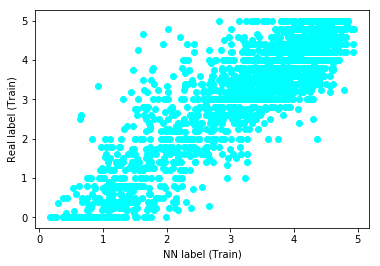

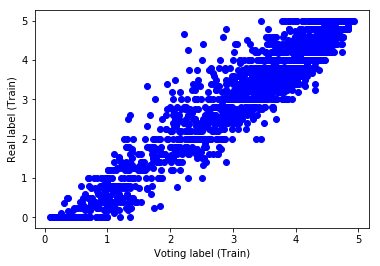

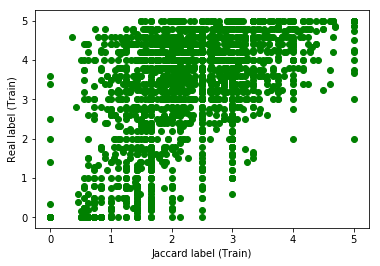

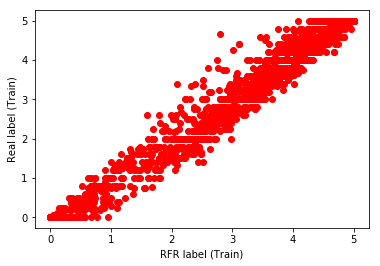

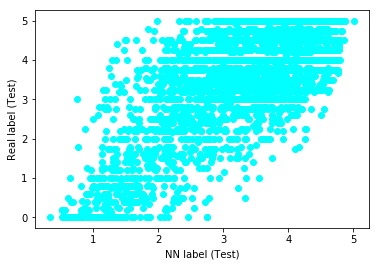

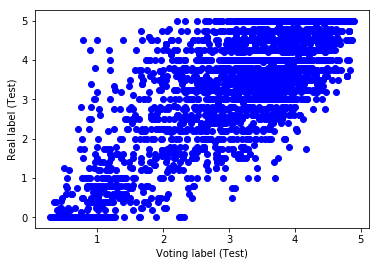

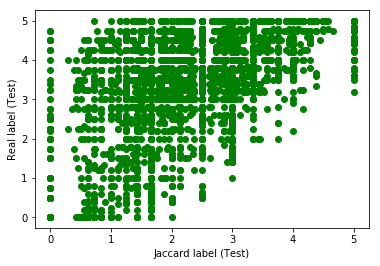

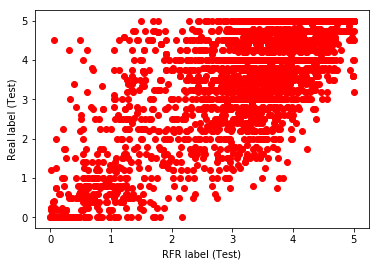

In [24]:
def __add_table(table, name, trn, tst):
    table.append_column(name, [
        '{:.2f} std: {:.1f}'.format(np.mean(trn), np.std(trn)),
        '{:.2f} std: {:.1f}'.format(np.mean(tst), np.std(tst)),
        '{:.4f}'.format(pearsonr(trn, trn_gs['labels'])[0]),
        '{:.4f}'.format(pearsonr(tst, tst_gs['labels'])[0])
    ])

table = BeautifulTable()
table.append_column('', ['Trn', 'Tst', 'Trn Pearson', 'Tst Pearson'])

__add_table(table, 'Real', trn_gs['labels'], tst_gs['labels'])
__add_table(table, 'RFR', predict_rfr_trn, predict_rfr_tst)
__add_table(table, 'Jaccard', predict_jac_trn, predict_jac_tst)
__add_table(table, 'NN', predict_nn_trn, predict_nn_tst)
__add_table(table, 'Voting', predict_avg_trn, predict_avg_tst)
print(table)
plt.scatter(predict_nn_trn, trn_gs['labels'], c='Cyan')
plt.xlabel('NN label (Train)')
plt.ylabel('Real label (Train)')
plt.show()
plt.scatter(predict_avg_trn, trn_gs['labels'], c='Blue')
plt.xlabel('Voting label (Train)')
plt.ylabel('Real label (Train)')
plt.show()
plt.scatter(predict_jac_trn, trn_gs['labels'], c='Green')
plt.xlabel('Jaccard label (Train)')
plt.ylabel('Real label (Train)')
plt.show()
plt.scatter(predict_rfr_trn, trn_gs['labels'], c='Red')
plt.xlabel('RFR label (Train)')
plt.ylabel('Real label (Train)')
plt.show()
plt.scatter(predict_nn_tst, tst_gs['labels'], c='Cyan')
plt.xlabel('NN label (Test)')
plt.ylabel('Real label (Test)')
plt.show()
plt.scatter(predict_avg_tst, tst_gs['labels'], c='Blue')
plt.xlabel('Voting label (Test)')
plt.ylabel('Real label (Test)')
plt.show()
plt.scatter(predict_jac_tst, tst_gs['labels'], c='Green')
plt.xlabel('Jaccard label (Test)')
plt.ylabel('Real label (Test)')
plt.show()
plt.scatter(predict_rfr_tst, tst_gs['labels'], c='Red')
plt.xlabel('RFR label (Test)')
plt.ylabel('Real label (Test)')
plt.show()

In [25]:
k = 10
print(k, 'Worst results in voting:')
err = np.abs(predict_avg_tst - tst_gs['labels'].values)
idx = np.argpartition(err, -k)[-k:]
dic = {err[i]: i for i in idx}  # Create a dictionary with the errors as the key for sorting output
for err in sorted(dic, reverse=True):
    i = dic[err]
    print(
        '\33[34mPredicted with avg: {:.2f} (RFR: {:.2f} NN: {:.2f} Jaccard: {:.2f}) Target: {:.2f} Err: {:.2f}\033[0m\n[{:s}]\n[{:s}]'
        .format(
            predict_avg_tst[i], predict_rfr_tst[i], predict_nn_tst[i], predict_jac_tst[i], tst_gs['labels'].values[i], err,
            str(tst['sentence0'].values[i]).replace('\n', '').replace('\r', ''),
            str(tst['sentence1'].values[i]).replace('\n', '').replace('\r', '')
        ))


10 Worst results in voting:
Predicted with avg: 0.79 (RFR: 0.06 NN: 1.51 Jaccard: 0.00) Target: 4.50 Err: 3.71
[a concern or affair]
[some situation or event that is thought about.]
Predicted with avg: 0.99 (RFR: 0.49 NN: 1.50 Jaccard: 0.00) Target: 4.50 Err: 3.51
[be against, resist]
[act against or in opposition to.]
Predicted with avg: 0.89 (RFR: 0.31 NN: 1.47 Jaccard: 0.00) Target: 4.25 Err: 3.36
[The act of having and controlling property.]
[the state or fact of being an owner.]
Predicted with avg: 1.39 (RFR: 1.12 NN: 1.66 Jaccard: 0.00) Target: 4.50 Err: 3.11
[Other ways are needed.]
[It is necessary to find other means.  ]
Predicted with avg: 1.67 (RFR: 1.39 NN: 1.94 Jaccard: 0.00) Target: 4.75 Err: 3.08
[Bring back to life, return from the dead]
[cause to become alive again.]
Predicted with avg: 1.18 (RFR: 0.60 NN: 1.76 Jaccard: 0.00) Target: 4.25 Err: 3.07
[Then perhaps we could have avoided a catastrophe.]
[We might have been able to prevent a disaster.]
Predicted with avg: 0